Note: It is recommended to train the model on a separate computer with GPU supports.

# Import Dependancies
- pandas
- keras
- matplotlib

In [1]:
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras import backend as K
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Set Training Parameters

In [2]:
batch_size = 128 # number of samples per each training in the dataset
num_classes = 10 # number of Y
epochs = 2 # number of training; assign 30 or more for better accuracy

# Data Acquisition
Each row consists of the label of the image as the first element, and rest of them are pixel values.

In [3]:
train = pd.read_csv('./data/train.csv').values
trainY = np_utils.to_categorical(train[:,0].astype('int32'), num_classes) # labels
trainX = train[:, 1:].astype('float32') # Pixel values
trainX /= 255 # Normalize values for training


# Reshape Data into Tensor with shape of 'input_shape' to Train Model
Turn 1D vector pixel values into 28x28 matrix as instruction noted.

Then change it into a Tensor of 28x28x1 which is the input shape that the model will use.

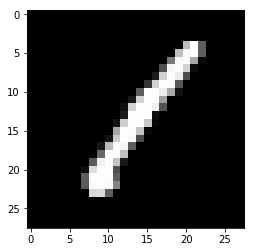

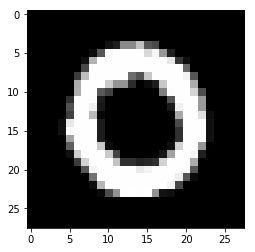

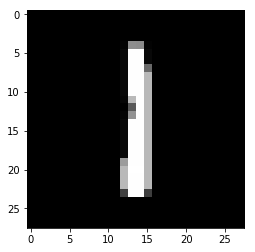

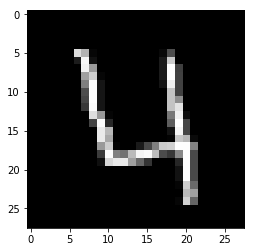

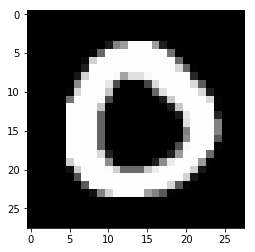

In [4]:
# Visulize 2D converted values
viz_trainX = trainX.reshape(trainX.shape[0], 28, 28)
for image in viz_trainX[:5]:
    plt.imshow(image, cmap='gray')
    plt.show()

In [7]:
# turn data to 3D tensor with shape of (28, 28, 1)
img_rows, img_cols = 28, 28

trainX = trainX.reshape(trainX.shape[0], img_rows, img_cols, 1)

input_shape = (img_rows, img_cols, 1)
trainX.shape

(42000, 28, 28, 1)

# Build Model
## Model Architecture
### Better models are welcome to be suggested
![Model Architecture][1]


  [1]: https://github.com/hskang9/kaggle-mnist/blob/master/model.png?raw=true

In [8]:

model = Sequential()
model.add(Conv2D(32,
                 data_format='channels_last',
                 kernel_size=(3,3),
                 activation='relu',
                 input_shape=input_shape)
                )
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))


# Compile model with Optimizer
model.compile(
              loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy']
             )

# Set Callbacks

A [callback][1] is a set of functions to be applied at given stages of the training procedure. I used EarlyStopping to prevent overtraining and Tensorboard for visualization


  [1]: https://keras.io/callbacks/

In [9]:
from keras.callbacks import EarlyStopping
from keras.callbacks import TensorBoard
callbacks = [
                # EarlyStopping stops training when model does not improve after epochs. interval can be configured with patience.
                EarlyStopping(
                              monitor="loss",
                              min_delta=0,
                              patience=3, 
                              verbose=0,
                              mode='auto'
                             ),
                # Tensorboard saves Tensorboard of the model after training
                TensorBoard(
                            log_dir='./logs',
                            histogram_freq=0,
                            batch_size=batch_size,
                            write_graph=True,
                            write_grads=False,
                            write_images=False, 
                            embeddings_freq=0, 
                            embeddings_layer_names=None,
                            embeddings_metadata=None
                           )
            ]

# Train Model

In [10]:
model.fit(
          trainX, trainY,
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          callbacks=callbacks
         )

score = model.evaluate(trainX, trainY, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

Epoch 1/2
 - 86s - loss: 0.4091 - acc: 0.8738
Epoch 2/2
 - 86s - loss: 0.1320 - acc: 0.9617
Train loss: 0.06243368265910872
Train accuracy: 0.9818571428571429


# Record Submission with Predictions from Test Data

In [11]:
# Change test data to Tensor with input shape
testX = pd.read_csv('./data/test.csv').values.astype('float32')
testX /= 255 # normalize each pixel
testX = testX.reshape(testX.shape[0], img_rows, img_cols, 1)

In [13]:
# Predict with trained model and record results on csv file
testY = model.predict_classes(testX, verbose=2)

pd.DataFrame({"ImageId": list(range(1,len(testY)+1)),
              "Label": testY}
            ).to_csv('submission.csv', index=False, header=True)